In [1]:
import torch
import os
import matplotlib.pyplot as plt
os.chdir("..")


from epilearn.models.Temporal.LSTM import LSTMModel
from epilearn.models.Temporal.GRU import GRUModel
from epilearn.models.Temporal.Dlinear import DlinearModel
from epilearn.models.Temporal.XGB import XGBModel
from epilearn.models.Temporal.ARIMA import VARMAXModel

from epilearn.data import UniversalDataset
from epilearn.utils import utils, transforms

# initial settings
device = torch.device('cpu')
torch.manual_seed(7)

lookback = 12 # inputs size
horizon = 3 # predicts size


permute = False

epochs = 50 # training epochs
batch_size = 50 # training batch size

In [2]:
# load toy dataset
dataset = UniversalDataset()
dataset.load_toy_dataset()

# initialize transforms
transformation = transforms.Compose({
                                    'features': [
                                                    transforms.normalize_feat(),

                                                ],
                                    "target": [transforms.normalize_feat()],
                                    'graph': [
                                                transforms.normalize_adj(),
                                                    
                                            ],
                                    'dynamic_graph': [
                                                        transforms.normalize_adj(),
                                                    
                                                    ],
                                    'states': []
                                    })

# preprocessing dataset
dataset.transforms = transformation

features, target, adj_norm, adj_dynamic_norm, states = dataset.get_transformed().values()
mean, std = dataset.transforms.feat_mean, dataset.transforms.feat_std

features = features.to(device)
adj_norm = adj_norm.to(device)
adj_dynamic_norm = adj_dynamic_norm.to(device)

# split data
train_rate = 0.6 
val_rate = 0.2

target_feat_idx = None
target_idx = None

split_line1 = int(features.shape[0] * train_rate)
split_line2 = int(features.shape[0] * (train_rate + val_rate))


train_original_input = features[:split_line1, :, :]
val_original_input = features[split_line1:split_line2, :, :]
test_original_input = features[split_line2:, :, :]

train_original_target = target[:split_line1, :]
val_original_target = target[split_line1:split_line2, :]
test_original_target = target[split_line2:, :]

train_original_states = dataset.states[:split_line1, :, :]
val_original_states = dataset.states[split_line1:split_line2, :, :]
test_original_states = dataset.states[split_line2:, :, :]


train_input, train_target, train_states, train_adj = dataset.generate_dataset(X = train_original_input, Y = train_original_target, states = train_original_states, dynamic_adj = adj_dynamic_norm, lookback_window_size = lookback, horizon_size = horizon, permute = permute)
val_input, val_target, val_states, val_adj = dataset.generate_dataset(X = val_original_input, Y = val_original_target, states = val_original_states, dynamic_adj = adj_dynamic_norm, lookback_window_size = lookback, horizon_size = horizon, permute = permute)
test_input, test_target, test_states, test_adj = dataset.generate_dataset(X = test_original_input, Y = test_original_target, states = test_original_states, dynamic_adj = adj_dynamic_norm, lookback_window_size = lookback, horizon_size = horizon, permute = permute)

# Selecting the first region for both input and target
train_input = train_input[:, :, 0, :]  # Selecting the first region across all timesteps and features
train_target = train_target[:, :, 0]  # Selecting the first region for the target

val_input = val_input[:, :, 0, :]
val_target = val_target[:, :, 0]

test_input = test_input[:, :, 0, :]
test_target = test_target[:, :, 0]

# shape of train_input: (num_samples, num_timesteps, num_features)

# prepare model

# model = GRUModel(
#             num_features=train_input.shape[2],
#             num_timesteps_input=lookback,
#             num_timesteps_output=horizon
#             ).to(device=device)

model = XGBModel(num_features=train_input.shape[2],
            num_timesteps_input=lookback,
            num_timesteps_output=horizon)

model = XGBModel(
    num_features=train_input.shape[2],
    num_timesteps_input=lookback,
    num_timesteps_output=horizon,
    n_estimators=40,        
    learning_rate=0.1,        
    max_depth=5,               
    reg_lambda=1.0,
    reg_alpha=0.1              
)

# model = VARMAXModel(num_features=train_input.shape[2],
#             num_timesteps_input=lookback,
#             num_timesteps_output=horizon)

# model = LSTMModel(
#             num_features = train_input.shape[2],
#             num_timesteps_input = lookback,
#             num_timesteps_output = horizon
#             ).to(device = device)


# model = DlinearModel(
#             num_features=train_input.shape[2],
#             num_timesteps_input=lookback,
#             num_timesteps_output=horizon
#             ).to(device=device)





In [3]:
train_input.shape

torch.Size([309, 12, 4])

In [4]:
# training
model.fit(
        train_input = train_input, 
        train_target = train_target, 
        # graph = adj_norm, 
        val_input = val_input, 
        val_target = val_target, 
        verbose = True,
        batch_size = batch_size,
        epochs = epochs)

[0]	validation_0-rmse:0.46699	validation_1-rmse:1.72105
[1]	validation_0-rmse:0.42560	validation_1-rmse:1.67931
[2]	validation_0-rmse:0.38826	validation_1-rmse:1.64257
[3]	validation_0-rmse:0.35467	validation_1-rmse:1.59979
[4]	validation_0-rmse:0.32411	validation_1-rmse:1.57312
[5]	validation_0-rmse:0.29625	validation_1-rmse:1.54601
[6]	validation_0-rmse:0.27111	validation_1-rmse:1.52189
[7]	validation_0-rmse:0.24841	validation_1-rmse:1.50249
[8]	validation_0-rmse:0.22791	validation_1-rmse:1.47878
[9]	validation_0-rmse:0.20930	validation_1-rmse:1.46537
[10]	validation_0-rmse:0.19249	validation_1-rmse:1.44612
[11]	validation_0-rmse:0.17739	validation_1-rmse:1.43219
[12]	validation_0-rmse:0.16341	validation_1-rmse:1.42136
[13]	validation_0-rmse:0.15073	validation_1-rmse:1.40654
[14]	validation_0-rmse:0.13946	validation_1-rmse:1.39599
[15]	validation_0-rmse:0.12900	validation_1-rmse:1.38604
[16]	validation_0-rmse:0.11970	validation_1-rmse:1.37926
[17]	validation_0-rmse:0.11122	validation

In [5]:

def get_MAE(pred, target):
    return torch.mean(torch.absolute(pred - target))

# evaluate
out = model.predict(feature = test_input)
preds = out.detach().cpu() * std[0] + mean[0]
targets = test_target.detach().cpu() * std[0] + mean[0]
# MAE
mae = get_MAE(preds, targets)
print(f"MAE: {mae.item()}")



MAE: 99.23118591308594


In [6]:
import matplotlib.pyplot as plt
import torch

out = model.predict(feature=train_input).detach().cpu()

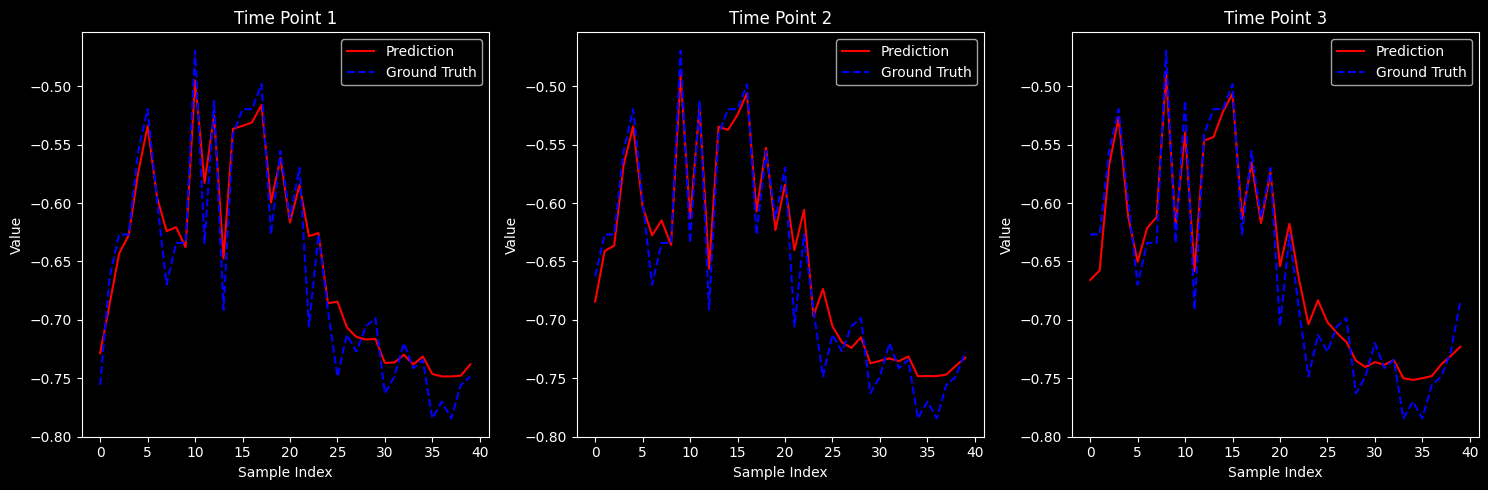

In [7]:
num_samples = 40  # Number of samples to display
time_points = 3  # Each sample predicts the next 3 time points

plt.figure(figsize=(15, 5))
for t in range(time_points):
    plt.subplot(1, 3, t + 1)
    
    # Gather all predictions and actual values for the t-th future time point across the first 40 samples
    predictions = out[:num_samples, t]
    truths = train_target[:num_samples, t]

    # Plotting the predictions and ground truth values
    plt.plot(range(num_samples), predictions.numpy(), 'r-', label='Prediction')
    plt.plot(range(num_samples), truths.numpy(), 'b--', label='Ground Truth')
    plt.title(f"Time Point {t + 1}")
    plt.xlabel("Sample Index")
    plt.ylabel("Value")
    plt.legend()

plt.tight_layout()
plt.show()